In [ ]:
# %% 
# # Cytoid-AI-charting

# %% 
# ## Data Preprocessing

# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
import json
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Tuple, Dict, Any
import enum
import tqdm

# Custom Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        Focal Loss function for handling class imbalance.

        Args:
            alpha (Tensor, optional): Weights for each class, shape (num_classes,). Default is None.
            gamma (float): Focusing parameter, default is 2.
            reduction (str): {'none', 'mean', 'sum'}, specifies the reduction to apply to the output, default is 'mean'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Forward pass.

        Args:
            inputs (Tensor): Model's unactivated outputs (logits), shape (batch_size, num_classes).
            targets (Tensor): True labels, shape (batch_size).

        Returns:
            Tensor: Computed Focal Loss.
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# STFT Constants
SAMPLE_RATE = 22050  
HOP_LENGTH = 512     
NMELS = 128        
FRAME = 32     

# %%
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %%
def contains_non_ascii(s: str) -> bool:
    """Check if the string contains non-ASCII characters."""
    return any(ord(c) > 127 for c in s)

def extract_level_json(directory: Path) -> Dict[str, Any]:
    """
    Extract level.json files from the directory and organize related information.
    
    Args:
        directory (Path): Main directory containing subfolders.
    
    Returns:
        Dict[str, Any]: Contains relevant information for each level.
    """
    result = {}
    
    for folder_path in directory.iterdir():
        json_file_path = folder_path / 'level.json'
        if json_file_path.is_file():
            with json_file_path.open('r', encoding='utf-8') as json_file:
                level_data = json.load(json_file)

            audio_file_name = level_data['music']['path']
            audio_file_extensions = ['.mp3', '.ogg', '.wav']
            audio_file_path = None

            for ext in audio_file_extensions:
                aud_path = folder_path / audio_file_name
                if aud_path.suffix.lower() == ext and aud_path.is_file():
                    audio_file_path = aud_path
                    break
            if audio_file_path is None:
                continue  

            charts_path = folder_path / level_data['charts'][0]['path']
            file_info = [
                ('audio', audio_file_path, level_data['music'], 'path', audio_file_path.suffix),
                ('chart', charts_path, level_data['charts'][0], 'path', '.json')
            ]
            for file_type, file_path, data_entry, path_key, file_extension in file_info:
                filename = file_path.name 
                if contains_non_ascii(filename):
                    if 'id' in level_data and level_data['id']:
                        new_filename = f"{level_data['id']}{file_extension}"
                        new_file_path = file_path.with_name(new_filename)
                        try:
                            file_path.rename(new_file_path)
                            data_entry[path_key] = new_filename
                            if file_type == 'audio':
                                audio_file_path = new_file_path
                            else:
                                charts_path = new_file_path
                        except Exception as e:
                            print(f"Failed to rename {file_type} file: {file_path}. Error: {e}")
                            continue
                    else:
                        print(f"Non-ASCII characters found in {file_type} file name: {file_path}")
                        continue
            result[level_data['id']] = {
                'level': level_data,
                'mp3_path': str(audio_file_path),
                'charts_path': str(charts_path),
                'charter': level_data.get('charter', ''),
                'type': level_data['charts'][0].get('type', ''),
                'difficulty': level_data['charts'][0].get('difficulty', '')
            }
    return result

# %%
def extract_charts(path: str) -> Dict[str, Any]:
    """
    Extract chart data from a JSON file.
    
    Args:
        path (str): Path to the chart JSON file.
    
    Returns:
        Dict[str, Any]: Chart data.
    """
    file_path = Path(path)
    if file_path.exists() and file_path.is_file():
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                return data
            except json.JSONDecodeError:
                print(f"JSON decode error for file: {path}")
    return {}

def find_single_tempo_songs(data: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Filter songs with constant BPM.
    
    Args:
        data (Dict[str, Any]): Dictionary containing all song information.
    
    Returns:
        List[Dict[str, Any]]: List of songs with constant BPM.
    """
    single_tempo_songs = []
    for song_id, song in data.items():
        charts_data = extract_charts(song['charts_path'])
        if charts_data and 'tempo_list' in charts_data:
            if len(charts_data['tempo_list']) == 1:
                single_tempo_songs.append(song)
    return single_tempo_songs

# %%
def map_note_to_time(data: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Map notes to time.
    
    Args:
        data (Dict[str, Any]): Chart data.
    
    Returns:
        List[Dict[str, Any]]: Time mapping information for each note.
    """
    time_base = data.get('time_base', 1000) 
    offset_universal = 0.033 
    offset = data.get('music_offset', 0) - offset_universal
    tempo_list = sorted(data.get('tempo_list', []), key=lambda x: x['tick'])  
    note_list = data.get('note_list', [])
    
    note_time_map = []
    accumulated_time = 0 
    last_tick = 0  
    if not tempo_list:
        return note_time_map
    current_tempo = tempo_list[0]['value']  
    tempo_index = 0  

    for note in note_list:
        note_tick = note['tick']
        while tempo_index < len(tempo_list) - 1 and tempo_list[tempo_index + 1]['tick'] <= note_tick:
            next_tempo_tick = tempo_list[tempo_index + 1]['tick']
            ticks_in_interval = next_tempo_tick - last_tick
            tick_duration = (current_tempo / time_base) 
            accumulated_time += ticks_in_interval * tick_duration
            last_tick = next_tempo_tick
            tempo_index += 1
            current_tempo = tempo_list[tempo_index]['value']

        ticks_in_interval = note_tick - last_tick
        tick_duration = (current_tempo / time_base) 
        note_time = accumulated_time + ticks_in_interval * tick_duration
        note_time_map.append({
            'note_id': note.get('id', 0),
            'note_tick': note_tick,
            'note_time_microseconds': note_time - offset * 1_000_000,
            'note_type': note.get('type', 0),
            'note_x': note.get('x', 0.0)
        })

    return note_time_map

# %%
def generate_mel_spectrogram(
    audio_path: Path,
    context_size: int = 5,
    log_enable: bool = True,
    bpm_info: List[Dict[str, float]] = None,
    note_info: List[Dict[str, Any]] = None,
    num_types: int = 5  # Changed to 5 types (0-4)
) -> dict:
    """
    Generate Mel spectrogram and corresponding labels.
    
    Args:
        audio_path (Path): Path to the audio file.
        context_size (int): Context window size.
        log_enable (bool): Whether to apply logarithmic transformation.
        bpm_info (List[Dict[str, float]]): BPM information.
        note_info (List[Dict[str, Any]]): Note information.
        num_types (int): Number of event types (0-4).
    
    Returns:
        dict: Dictionary containing Mel spectrogram and labels.
    """
    data, sr = librosa.load(str(audio_path), sr=SAMPLE_RATE)
    assert sr == SAMPLE_RATE, f"Expected sample rate {SAMPLE_RATE}, but got {sr}"

    mel = librosa.feature.melspectrogram(
        y=data,
        sr=sr, 
        hop_length=HOP_LENGTH, 
        fmin=30.0, 
        n_mels=NMELS, 
        htk=True
    )
    if log_enable:
        mel = np.log(np.clip(mel, 1e-5, None))
    mel = mel.T  # (time steps, features)

    # Build context window
    pad_width = context_size
    padded_mel = np.pad(mel, ((pad_width, pad_width), (0, 0)), mode='edge')
    context_mel = np.array([
        padded_mel[i - context_size:i + context_size + 1].flatten()
        for i in range(context_size, len(mel) + pad_width)
    ])

    data_dic = {"mel": context_mel}

    if bpm_info and note_info:
        mel_length = mel.shape[0]
        labels = np.zeros(mel_length, dtype=int)  # Initialize as type 0 (no note)
        for note in note_info:
            time_sec = note['note_time_microseconds'] / 1_000_000
            frame_idx = int(time_sec * SAMPLE_RATE / HOP_LENGTH)
            if frame_idx < mel_length:
                original_type = note['note_type']
                if original_type in [0, 5]:
                    new_label = 1
                elif original_type in [1, 2]:
                    new_label = 2
                elif original_type in [3, 4]:
                    new_label = 3
                elif original_type in [6, 7]:
                    new_label = 4
                else:
                    continue  # Other types remain as 0 (no note)
                labels[frame_idx] = new_label
        data_dic["labels"] = labels  # Shape: (mel_length,)

    return data_dic

# %%
class OnsetDataset(Dataset):
    """
    PyTorch Dataset class for loading and providing data.
    """
    def __init__(self, data: Dict[str, Any], bpm_info: Dict[str, List[Dict[str, float]]], score_positions: Dict[str, List[Dict[str, Any]]], transform=None, num_types: int =5):
        self.data = data
        self.bpm_info = bpm_info
        self.score_positions = score_positions
        self.transform = transform
        self.num_types = num_types
        self.samples = self.prepare_samples()
        
    def prepare_samples(self) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Prepare data samples.
        
        Returns:
            List[Tuple[np.ndarray, np.ndarray]]: List of samples containing Mel spectrogram and type labels.
        """
        samples = []
        for song_id, song in self.data.items():
            mp3_path = song["mp3_path"]
            charts_path = song["charts_path"]
            difficulty = song['difficulty']  # Extract difficulty level

            mel_dict = generate_mel_spectrogram(
                audio_path=Path(mp3_path),
                context_size=5,
                log_enable=True,
                bpm_info=self.bpm_info.get(song_id, None),
                note_info=self.score_positions.get(song_id, None),
                num_types=self.num_types
            )
            if "labels" in mel_dict:
                mel = mel_dict["mel"]  # shape: (num_frames, context_window_size * n_mels)
                labels = mel_dict["labels"]  # shape: (num_frames,)
                # Optional: Add difficulty level or other info if needed
                samples.append((mel, labels))
        return samples
        
    def __len__(self) -> int:
        return len(self.samples)
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        mel, labels = self.samples[idx]
        mel = torch.from_numpy(mel).float()  # shape: (num_frames, input_size)
        labels = torch.from_numpy(labels).long()  # shape: (num_frames,)

        if self.transform:
            mel, labels = self.transform(mel, labels)

        return mel, labels

# %%
class TimeUnit(enum.Enum):
    milliseconds = "milliseconds"
    frames = "frames"
    seconds = "seconds"

def process_bpminfo(
    bpm_info: List[Dict[str, float]],  
    max_length_ms: int,
    units: 'TimeUnit' = 'TimeUnit.milliseconds'
) -> Tuple[List[float], List[float], List[float], List[int]]:
    """
    Process BPM information to generate beat arrays.
    
    Args:
        bpm_info (List[Dict[str, float]]): List of BPM information.
        max_length_ms (int): Maximum length in milliseconds.
        units (TimeUnit): Time units.
    
    Returns:
        Tuple[List[float], List[float], List[float], List[int]]: BPM list, start times, end times, and beats per measure.
    """
    bpms, starts, ends, beats = [], [], [], []
    max_length = convert_units(max_length_ms, units)

    for i, tempo_event in enumerate(bpm_info):
        tick = tempo_event['tick']
        value = tempo_event['value']
        start = convert_units(tick * FRAME, TimeUnit.milliseconds) 
        if start > max_length:
            continue
        bpm = 60000000 / value  
        bpms.append(bpm)
        starts.append(start)
        beats.append(4)  # Assume 4 beats per measure
        if i < len(bpm_info) - 1:
            next_tick = bpm_info[i + 1]['tick']
            next_start = convert_units(next_tick * FRAME, TimeUnit.milliseconds)
            ends.append(min(next_start, max_length))
        else:
            ends.append(max_length)

    return bpms, starts, ends, beats

def convert_units(value: float, units: 'TimeUnit') -> float:
    """
    Convert time units.
    
    Args:
        value (float): Value to convert.
        units (TimeUnit): Target units.
    
    Returns:
        float: Converted value.
    """
    if units == TimeUnit.milliseconds:
        return float(value)
    elif units == TimeUnit.seconds:
        return float(value) / 1000.0
    elif units == TimeUnit.frames:
        return float(value) * FRAME  
    else:
        raise ValueError("convert_units error")

def gen_beats_array(
    length: int,
    bpm_info: List[Dict[str, float]],  # tempo_list [{'tick': 0, 'value': 300000}]
    mel_length: int,
    is_downbeat: bool = True,
):
    """
    Generate a beat array.
    
    Args:
        length (int): Total length.
        bpm_info (List[Dict[str, float]]): List of BPM information.
        mel_length (int): Number of Mel spectrogram frames.
        is_downbeat (bool): Whether it is a downbeat.
    
    Returns:
        np.ndarray: Beat array.
    """
    arr = np.zeros(length)
    bpms, starts, ends, beats = process_bpminfo(
        bpm_info, mel_length * FRAME, units=TimeUnit.milliseconds
    )
    for bpm, start, end, beat in zip(bpms, starts, ends, beats):
        interval = 60000 / bpm  # Milliseconds
        beats_timing = np.arange(start, end, interval)
        arg_beats = np.round(beats_timing / FRAME).astype("int64")
        arg_beats = arg_beats[arg_beats < length]  

        for b in range(beat):
            if b == 0:  #
                if is_downbeat:
                    arr[arg_beats[b::beat]] = 2
                else:
                    arr[arg_beats[b::beat]] = 1
            else:  
                arr[arg_beats[b::beat]] = 1

    return arr.reshape([-1, 1])

def add_white_noise(x: np.ndarray, rate: float = 0.005) -> np.ndarray:
    """Add white noise to audio data."""
    return x + rate * np.random.randn(len(x))

def shift(ar: torch.Tensor, size: int, med: int) -> torch.Tensor:
    """Shift tensor."""
    if size > 0:
        ar = F.pad(ar[size:], (0, size)) + F.pad(ar[:-size], (size, 0))
    ar = ar * (med - size)
    return ar

def gauss(ar: torch.Tensor, width: int = 3, scale: float = 1.0) -> torch.Tensor:
    """Apply Gaussian filtering."""
    t = torch.stack([shift(ar, i, width) for i in range(width)])
    t = torch.max(t, dim=0)[0]
    mask = t == 0
    std = width / 3
    var = std**2
    t2 = torch.exp(-((t - width) ** 2) / (2 * var)) * scale
    return torch.max(t2.masked_fill(mask, 0), ar.float())

def round_decimal(tensor: torch.Tensor, decimals: int) -> torch.Tensor:
    """Round tensor to specified decimal places."""
    multiplier = 10 ** decimals
    return torch.round(tensor * multiplier) / multiplier

def fuzzy_label(onset_label: torch.Tensor, width: int, scale: float) -> torch.Tensor:
    """Generate fuzzy labels."""
    assert width > 0
    assert 0 <= scale <= 1
    return round_decimal(gauss(onset_label.view(-1), width, scale), 2).view(len(onset_label), 1)

def fuzzy_on_batch(batch: torch.Tensor, width: int, scale: float) -> torch.Tensor:
    """Apply fuzzy labels to the entire batch."""
    fuzzy_labeled = []
    for x in range(batch.shape[0]):
        fuzzy_labeled.append(fuzzy_label(batch[x], width, scale))
    return torch.stack(fuzzy_labeled)

# %%
def multi_task_loss(type_pred, type_target, num_types=5):
    """
    Compute multi-task loss (only type prediction).
    
    Args:
        type_pred (Tensor): Predicted event types, shape (batch_size, seq_len, num_types)
        type_target (Tensor): True event types, shape (batch_size, seq_len)
        num_types (int): Number of event types.
    
    Returns:
        Tensor: Total loss.
    """
    # Event type loss (cross-entropy)
    # Reshape for CrossEntropyLoss: (batch_size * seq_len, num_types)
    type_pred = type_pred.view(-1, num_types)
    type_target = type_target.view(-1).long()
    loss_type = nn.CrossEntropyLoss()(type_pred, type_target)

    return loss_type

# %%
class MultiTaskLSTM(nn.Module):
    """
    Multi-task learning LSTM model for predicting note types.
    """
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, num_types: int, dropout: float = 0.5):
        super(MultiTaskLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # Output layers
        self.fc_type = nn.Linear(hidden_size * 2, num_types)  # Event types (multi-class)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x (torch.Tensor): Input features, shape (batch_size, seq_len, input_size)
        
        Returns:
            torch.Tensor: type_pred
        """
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_size * 2)

        # Event types
        type_out = self.fc_type(lstm_out)  # (batch_size, seq_len, num_types)
        # Note: CrossEntropyLoss applies Softmax internally

        return type_out

# %% 
# ## Network

# %% 
# ### Input Preprocessing

# %%
def collate_fn_padded(batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor, List[int]]:
    """
    Custom collate_fn for handling variable-length sequences in batches.
    
    Args:
        batch (List[Tuple[torch.Tensor, torch.Tensor]]): A batch of data.
    
    Returns:
        Tuple[torch.Tensor, torch.Tensor, List[int]]: Padded Mel spectrograms, type labels, and lengths of each sample.
    """
    mel, labels = zip(*batch)
    lengths = [m.shape[0] for m in mel]
    
    # Pad Mel spectrograms
    mel_padded = pad_sequence(mel, batch_first=True, padding_value=0)  # (batch_size, max_seq_len, input_size)
    
    # Pad labels
    labels_padded = pad_sequence([l.unsqueeze(1) for l in labels], batch_first=True, padding_value=0).squeeze(2)  # (batch_size, max_seq_len)
    
    return mel_padded, labels_padded, lengths

# %% 
# ## Training and Evaluation

# %%
def compute_accuracy(type_pred, type_target, num_types=5):
    """
    Compute accuracy.
    
    Args:
        type_pred (Tensor): Predicted event types, shape (batch_size, seq_len, num_types)
        type_target (Tensor): True event types, shape (batch_size, seq_len)
        num_types (int): Number of event types.
    
    Returns:
        float: Accuracy.
    """
    _, preds = torch.max(type_pred, dim=-1)
    correct = (preds == type_target).float()
    acc = correct.sum() / len(correct)
    return acc.item()

def train_epoch(model: nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, device: torch.device, num_types: int, class_weights: torch.Tensor = None) -> Tuple[float, float]:
    """
    Train for one epoch.
    
    Args:
        model (nn.Module): Model.
        dataloader (DataLoader): Training data loader.
        optimizer (torch.optim.Optimizer): Optimizer.
        device (torch.device): Device.
        num_types (int): Number of event types.
        class_weights (torch.Tensor, optional): Class weights for handling data imbalance.
    
    Returns:
        Tuple[float, float]: Average loss and average accuracy.
    """
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    progress_bar = tqdm.tqdm(dataloader, desc="Training", leave=False)

    # Define Focal Loss
    criterion = FocalLoss(alpha=class_weights, gamma=2, reduction='mean') if class_weights is not None else FocalLoss(gamma=2, reduction='mean')

    for mel, labels, lengths in progress_bar:
        mel = mel.to(device)  # (batch_size, seq_len, input_size)
        labels = labels.to(device)  # (batch_size, seq_len)

        optimizer.zero_grad()

        # Forward pass
        type_pred = model(mel)  # (batch_size, seq_len, num_types)

        # Compute loss
        type_pred_flat = type_pred.view(-1, num_types)
        labels_flat = labels.view(-1).long()

        loss = criterion(type_pred_flat, labels_flat)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        acc = compute_accuracy(type_pred, labels, num_types)
        running_acc += acc

        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{acc*100:.2f}%'})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_acc / len(dataloader)
    return epoch_loss, epoch_acc

def validate_epoch(model: nn.Module, dataloader: DataLoader, device: torch.device, num_types: int, class_weights: torch.Tensor = None) -> Tuple[float, float]:
    """
    Evaluate the model on the validation set.
    
    Args:
        model (nn.Module): Model.
        dataloader (DataLoader): Validation data loader.
        device (torch.device): Device.
        num_types (int): Number of event types.
        class_weights (torch.Tensor, optional): Class weights for handling data imbalance.
    
    Returns:
        Tuple[float, float]: Average loss and average accuracy.
    """
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    progress_bar = tqdm.tqdm(dataloader, desc="Validation", leave=False)

    # Define Focal Loss
    criterion = FocalLoss(alpha=class_weights, gamma=2, reduction='mean') if class_weights is not None else FocalLoss(gamma=2, reduction='mean')

    with torch.no_grad():
        for mel, labels, lengths in progress_bar:
            mel = mel.to(device)
            labels = labels.to(device)

            # Forward pass
            type_pred = model(mel)

            # Compute loss
            type_pred_flat = type_pred.view(-1, num_types)
            labels_flat = labels.view(-1).long()

            loss = criterion(type_pred_flat, labels_flat)

            running_loss += loss.item()

            # Compute accuracy
            acc = compute_accuracy(type_pred, labels, num_types)
            running_acc += acc

            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{acc*100:.2f}%'})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_acc / len(dataloader)
    return epoch_loss, epoch_acc

# %%
# Data Preparation
current_directory = Path().cwd()
data = extract_level_json(current_directory / "dataset/Z")  # raw data
single_tempo_songs = find_single_tempo_songs(data)  # single tempo songs

bpm_info_dict = {}
score_positions_dict = {}

for song in single_tempo_songs:
    song_id = song['level']['id']
    charts_data = extract_charts(song['charts_path'])
    if charts_data:
        bpm_info = charts_data.get('tempo_list', [])
        bpm_info_dict[song_id] = bpm_info
        note_time_map = map_note_to_time(charts_data) 
        # Detailed information for each note, including time, type, and position
        score_positions = [] 
        for note in note_time_map:
            score_positions.append({
                'note_time_microseconds': note['note_time_microseconds'],
                'note_type': note['note_type'],  # Ensure this field exists
                'note_x': note['note_x']         # Ensure this field exists
            })
        score_positions_dict[song_id] = score_positions

# Create dataset
dataset = OnsetDataset(data=data, bpm_info=bpm_info_dict, score_positions=score_positions_dict, num_types=5)

print(f"Total Samples: {len(dataset)}")

# %%
# Compute class weights to handle data imbalance
all_labels = []
for _, labels in dataset.samples:
    all_labels.extend(labels.tolist())

label_counts = Counter(all_labels)
total = sum(label_counts.values())
print("Label Distribution:")
for label, count in label_counts.items():
    print(f"Type {label}: {count} samples ({count/total*100:.2f}%)")

class_weights = torch.tensor([total / (len(label_counts) * label_counts.get(i, 1)) for i in range(5)]).to(device)
print(f"Class Weights: {class_weights}")

# %%
# Hyperparameters
input_size = NMELS * (2 * 5 + 1)  # context_size=5, so window=11, input_size=128*11=1408
hidden_size = 256  # Increased hidden layer size
num_layers = 5     # Increased number of LSTM layers
num_types = 5  # Updated to 5 types
dropout = 0.5
num_epochs = 10  # Increased number of training epochs
batch_size = 16
learning_rate = 0.0001  # Lowered learning rate

# %%
# Dataset Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# %%
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn_padded)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn_padded)

print(f"Train Size: {len(train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")

# %%
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from matplotlib.lines import Line2D

def visualize_predictions(mel: np.ndarray, labels: np.ndarray, preds: np.ndarray, 
                          start_time: float = 0, end_time: float = 5, 
                          hop_length: int = 512, sample_rate: int = 22050):
    # Apply Softmax to get probabilities
    preds_prob = F.softmax(torch.tensor(preds), dim=-1).numpy()

    # Calculate time axis
    total_time = mel.shape[0] * hop_length / sample_rate
    times = np.linspace(0, total_time, num=mel.shape[0])

    # Determine frame range for visualization
    start_frame = int(start_time * sample_rate / hop_length)
    end_frame = int(end_time * sample_rate / hop_length)

    # Crop data
    labels_cropped = labels[start_frame:end_frame]
    preds_cropped = preds_prob[start_frame:end_frame]
    times_cropped = times[start_frame:end_frame]

    # Define color mapping (using matplotlib's tab10 color set)
    cmap = plt.get_cmap('tab10')
    num_types = preds_cropped.shape[1]
    colors = [cmap(i) for i in range(num_types)]

    # Create plot
    plt.figure(figsize=(15, 8))

    # Plot type probabilities
    for type_idx in range(num_types):
        plt.plot(
            times_cropped,
            preds_cropped[:, type_idx],
            label=f'Type {type_idx}',
            color=colors[type_idx],
            alpha=0.6
        )

    # Plot true labels
    for idx, label in enumerate(labels_cropped):
        if label == 0:
            continue  # Skip type 0 (assumed to be no event)
        plt.scatter(
            
            times_cropped[idx],
            preds_cropped[idx, label],
            color=colors[label],
            marker='x',
            s=50,
            label=f'Ground Truth Type {label}' if idx == 0 else "",  # Add to legend only once
            zorder=5
        )
        # Draw vertical line
        plt.axvline(
            x=times_cropped[idx],
            color=colors[label],
            linestyle='--',
            alpha=0.5,
            linewidth=1
        )

    # Add title and labels
    plt.title('Type Probabilities and Ground Truth', fontsize=14)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Probability', fontsize=12)

    # Set legend without duplicates
    handles, labels_legend = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels_legend, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small')

    # Set x-axis range
    plt.xlim(start_time, end_time)

    # Show y-axis labels only on the right
    ax = plt.gca()
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.yaxis.set_label_coords(1.05, 0.5)

    # Display plot
    plt.tight_layout()
    plt.show()


Using device: cuda
Failed to rename chart file: /data1/yuchen/cytoid/code/dataset/Z/zv4.chuni.1.cytoidlevel/easy - 副本.json. Error: [Errno 2] No such file or directory: '/data1/yuchen/cytoid/code/dataset/Z/zv4.chuni.1.cytoidlevel/easy - 副本.json' -> '/data1/yuchen/cytoid/code/dataset/Z/zv4.chuni.1.cytoidlevel/zv4.chuni.1.json'
Failed to rename chart file: /data1/yuchen/cytoid/code/dataset/Z/zeng.loveandj.cytoidlevel/loveand - 副本.txt. Error: [Errno 2] No such file or directory: '/data1/yuchen/cytoid/code/dataset/Z/zeng.loveandj.cytoidlevel/loveand - 副本.txt' -> '/data1/yuchen/cytoid/code/dataset/Z/zeng.loveandj.cytoidlevel/zeng.loveandj.json'
Failed to rename chart file: /data1/yuchen/cytoid/code/dataset/Z/zeng.emp.cytoidlevel/emp - 副本.txt. Error: [Errno 2] No such file or directory: '/data1/yuchen/cytoid/code/dataset/Z/zeng.emp.cytoidlevel/emp - 副本.txt' -> '/data1/yuchen/cytoid/code/dataset/Z/zeng.emp.cytoidlevel/zeng.emp.json'
Total Samples: 66
Label Distribution:
Type 0: 345427 samples 

Epoch 1/10, Train Loss: 0.6474, Train Acc: 411416.67%, Val Loss: 1.1068, Val Acc: 299342.87%


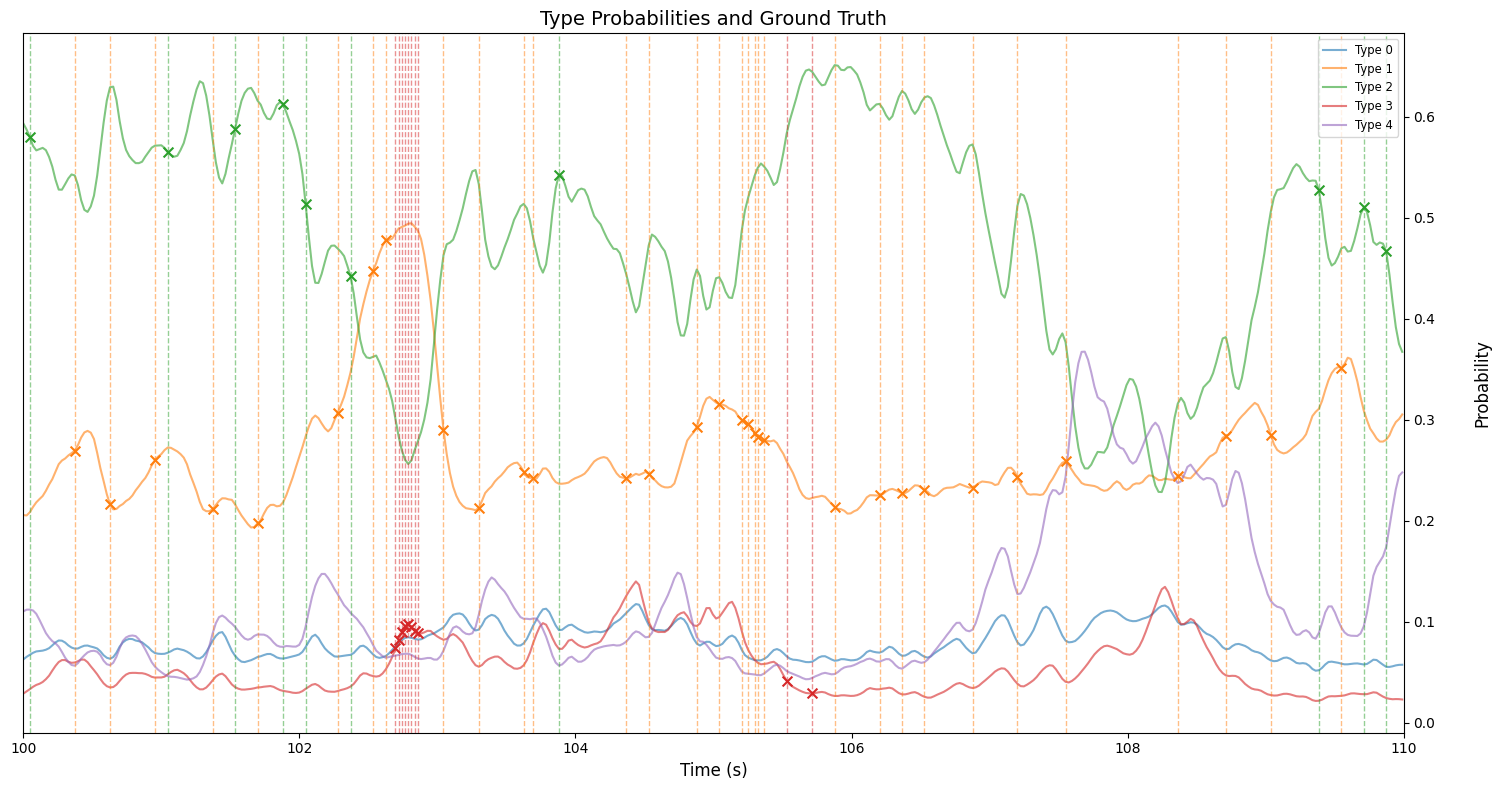

Epoch 2/10, Train Loss: 0.6175, Train Acc: 435785.42%, Val Loss: 1.1533, Val Acc: 298928.59%


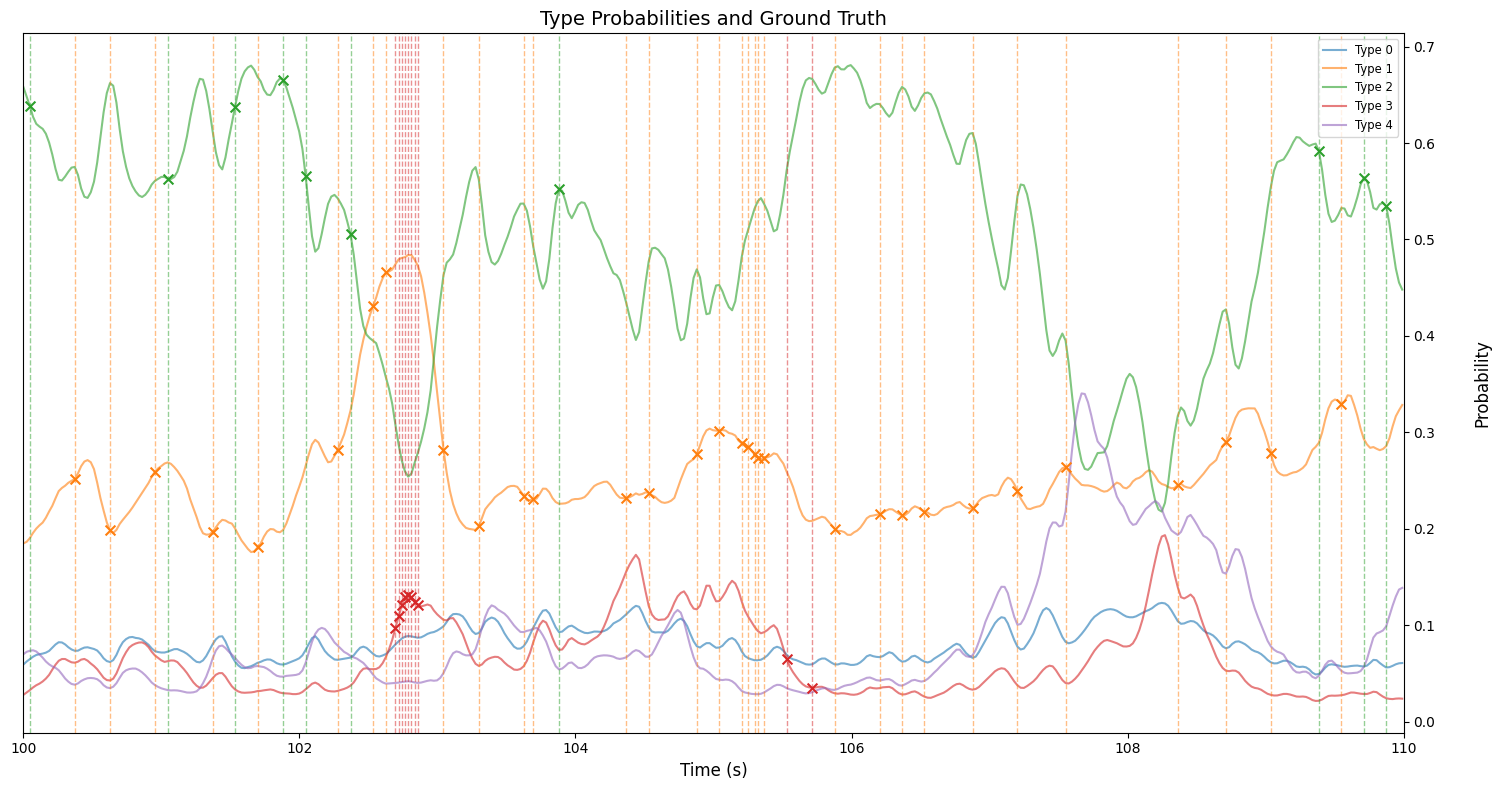

Epoch 3/10, Train Loss: 0.5694, Train Acc: 495679.17%, Val Loss: 1.1360, Val Acc: 291150.02%


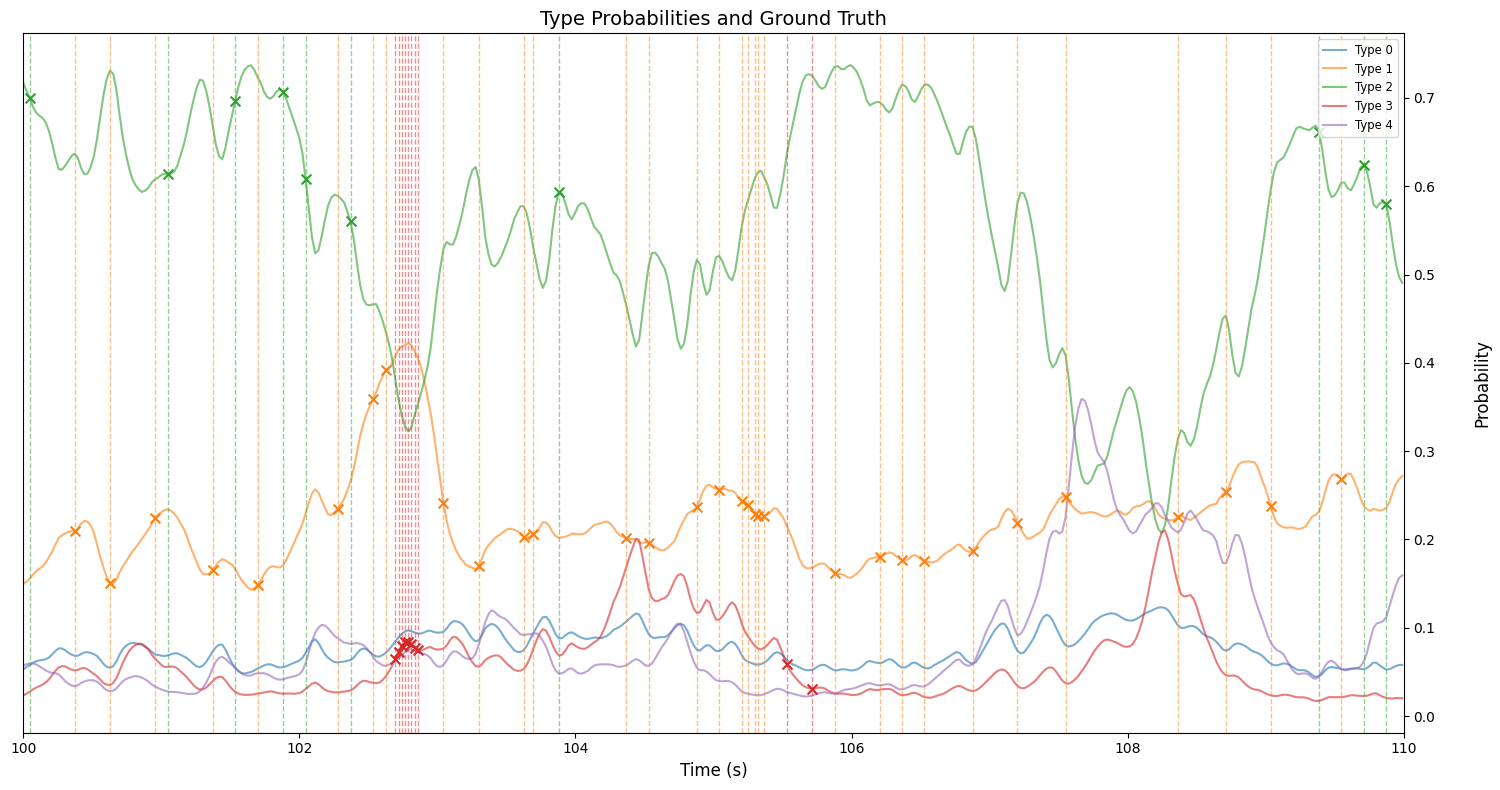

Epoch 4/10, Train Loss: 0.5800, Train Acc: 468427.08%, Val Loss: 1.2438, Val Acc: 304557.15%


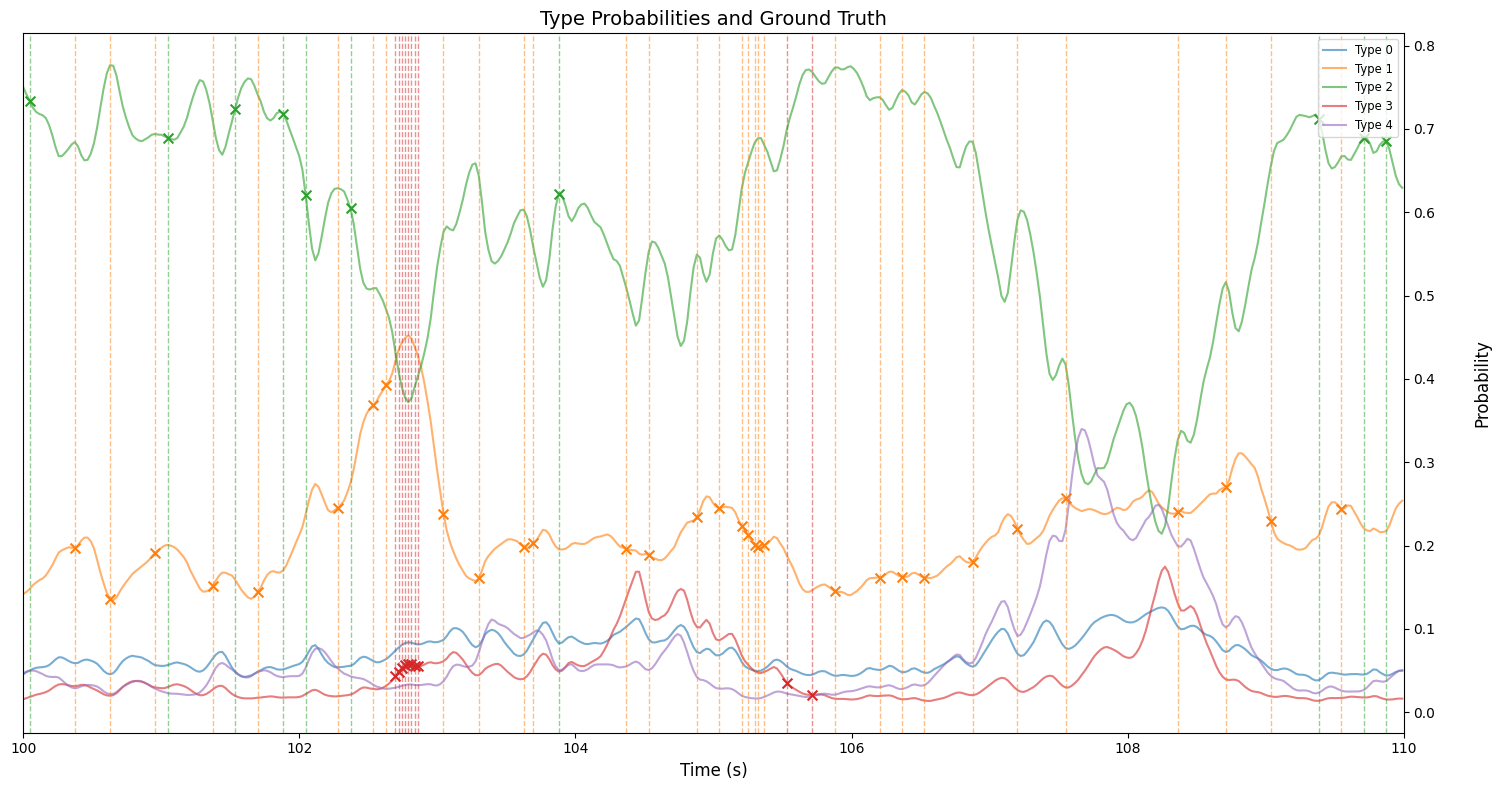

Epoch 5/10, Train Loss: 0.6105, Train Acc: 452966.67%, Val Loss: 1.1783, Val Acc: 301128.59%


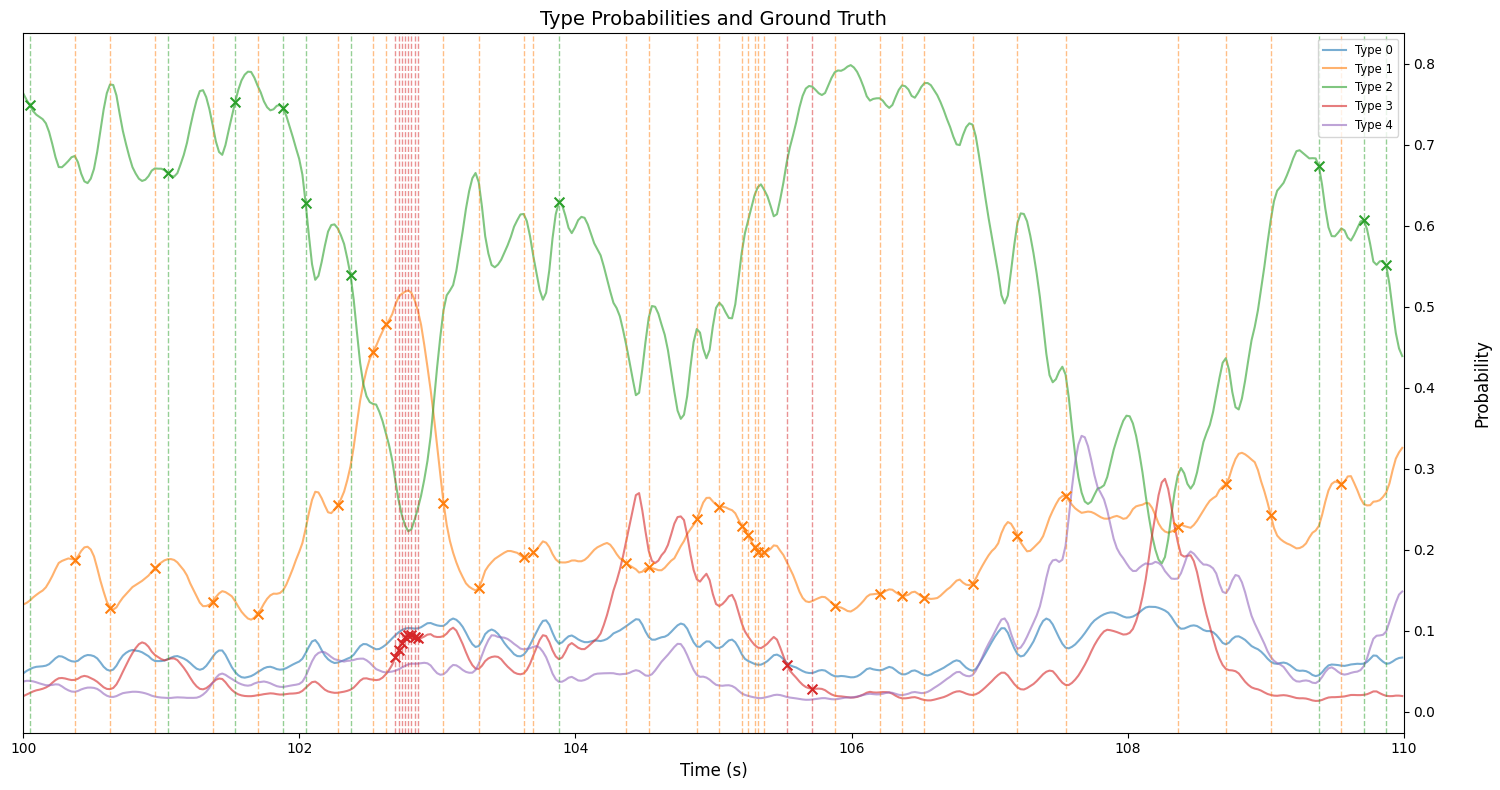

Epoch 6/10, Train Loss: 0.5445, Train Acc: 509747.92%, Val Loss: 1.2371, Val Acc: 302350.02%


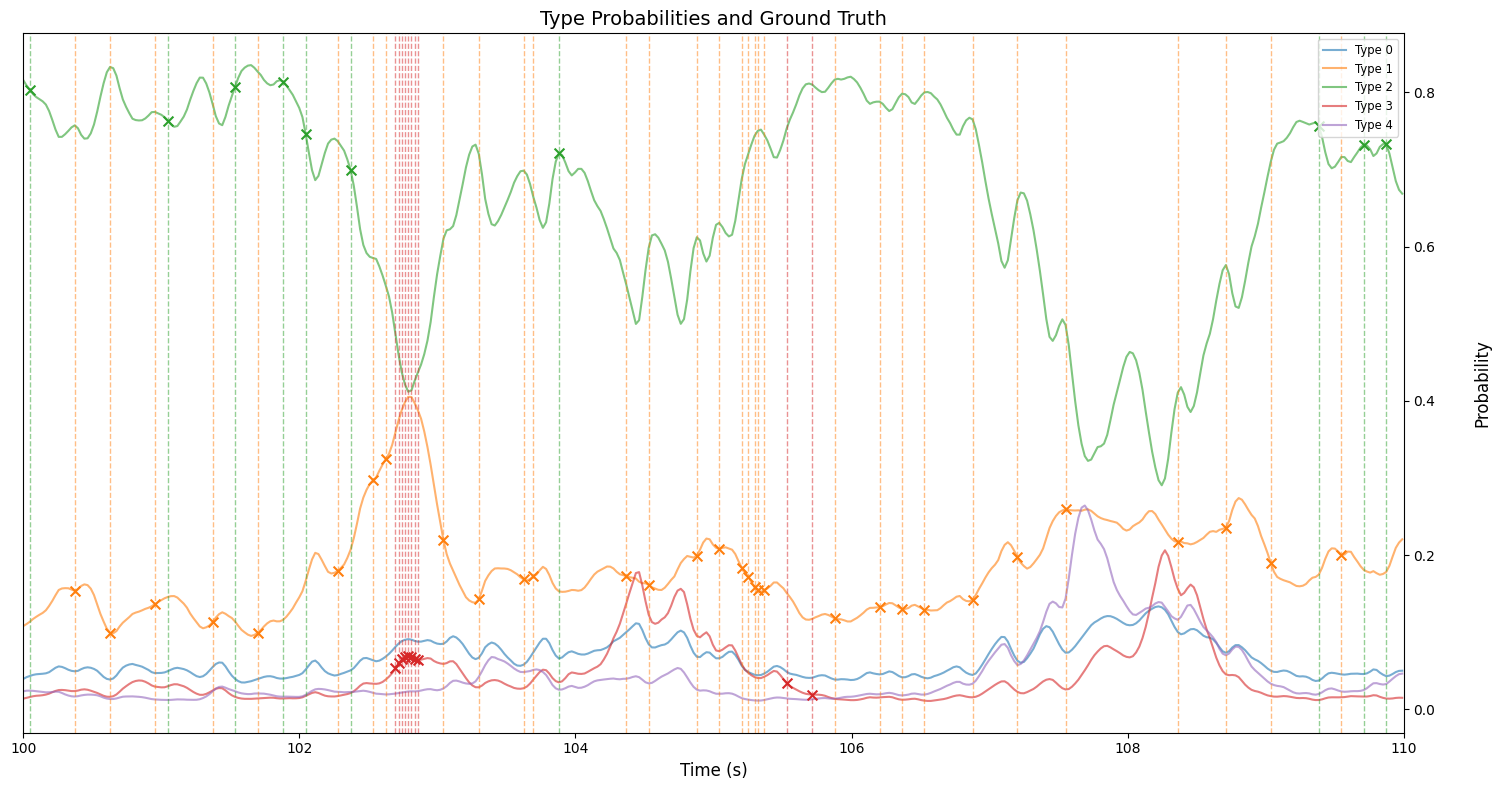

Epoch 7/10, Train Loss: 0.5650, Train Acc: 465895.83%, Val Loss: 1.1935, Val Acc: 309221.44%


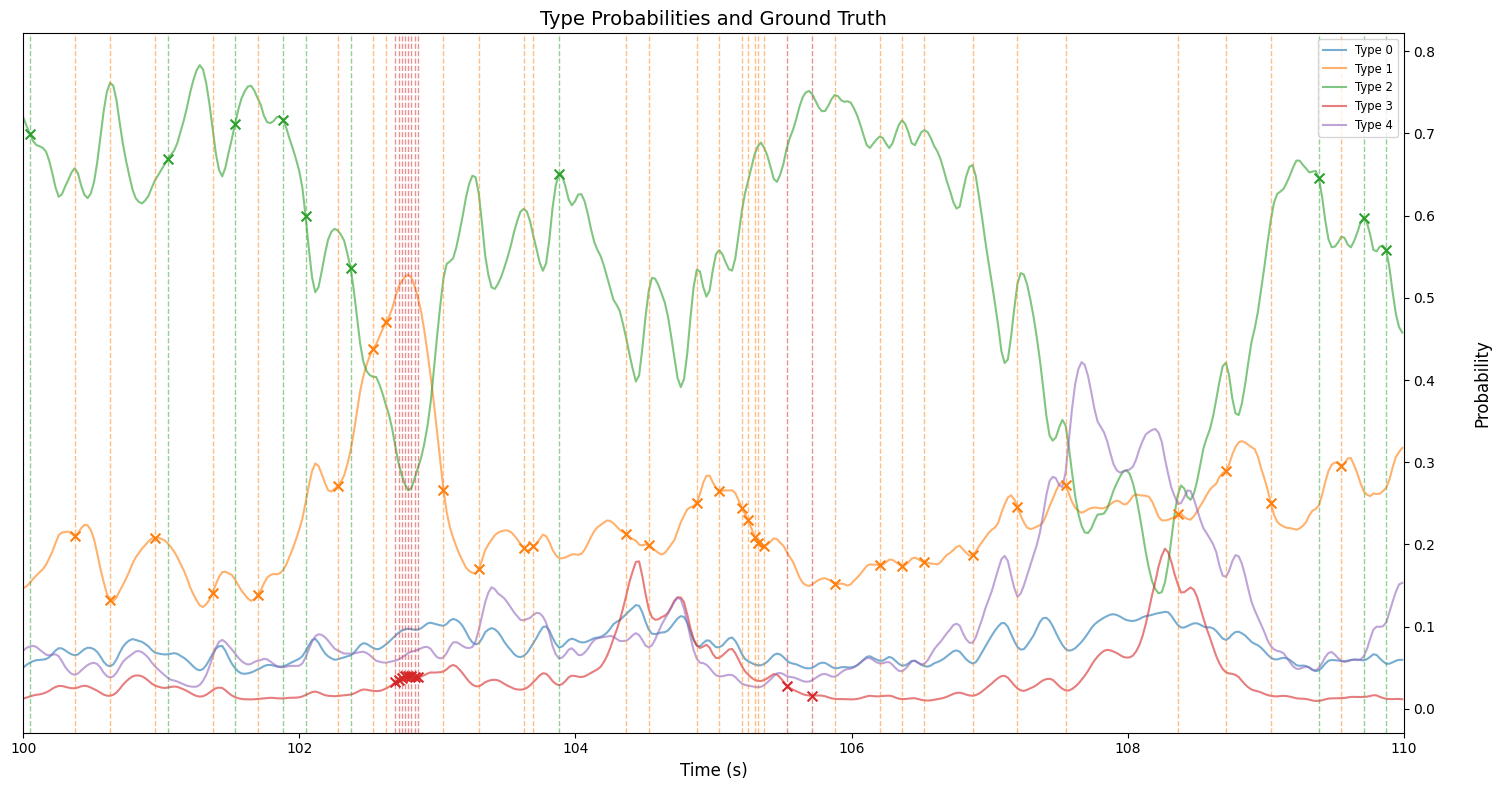

Epoch 8/10, Train Loss: 0.5858, Train Acc: 433210.42%, Val Loss: 1.3205, Val Acc: 302714.31%


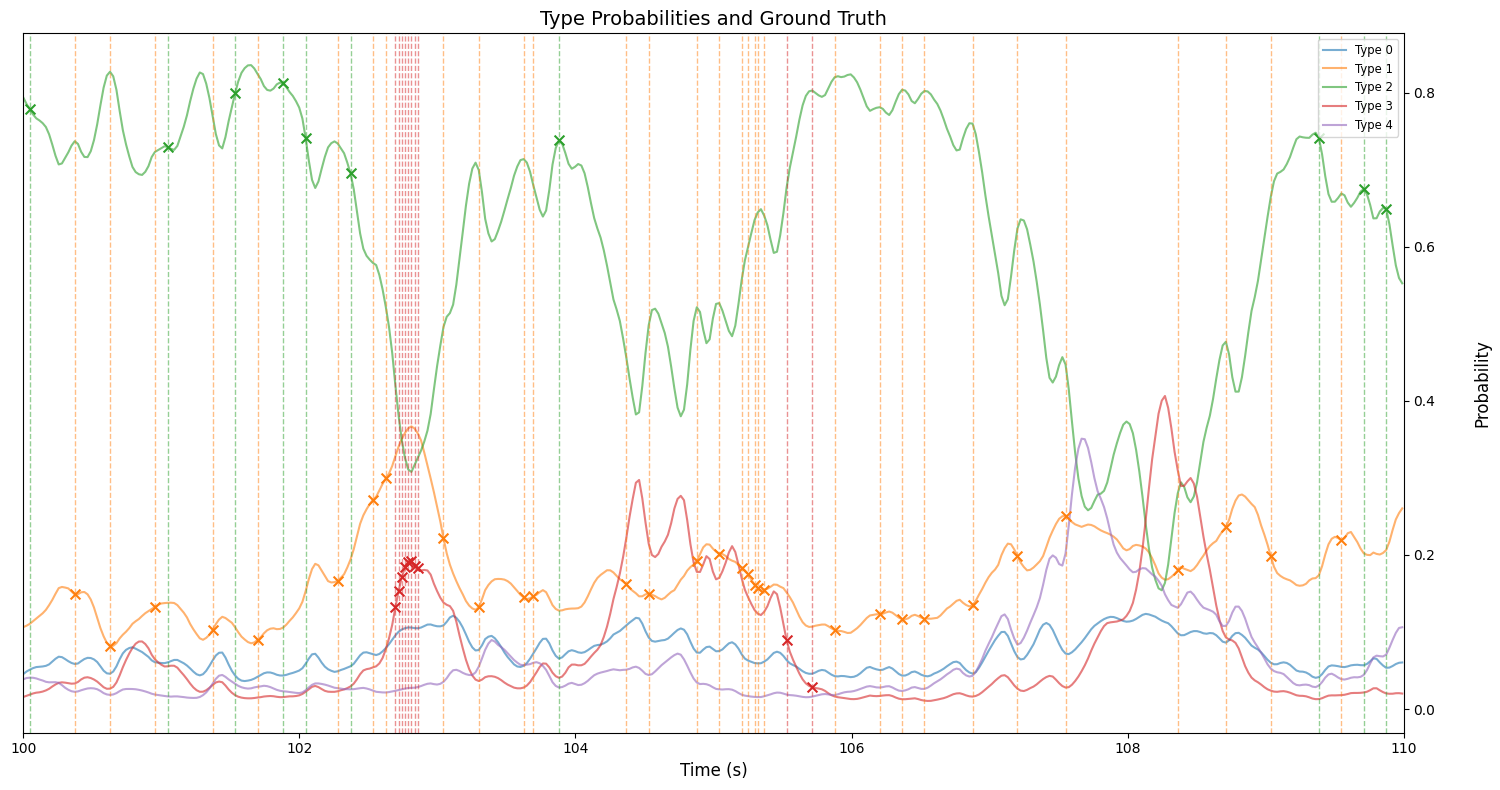

Epoch 9/10, Train Loss: 0.5701, Train Acc: 451175.00%, Val Loss: 1.2076, Val Acc: 305264.31%


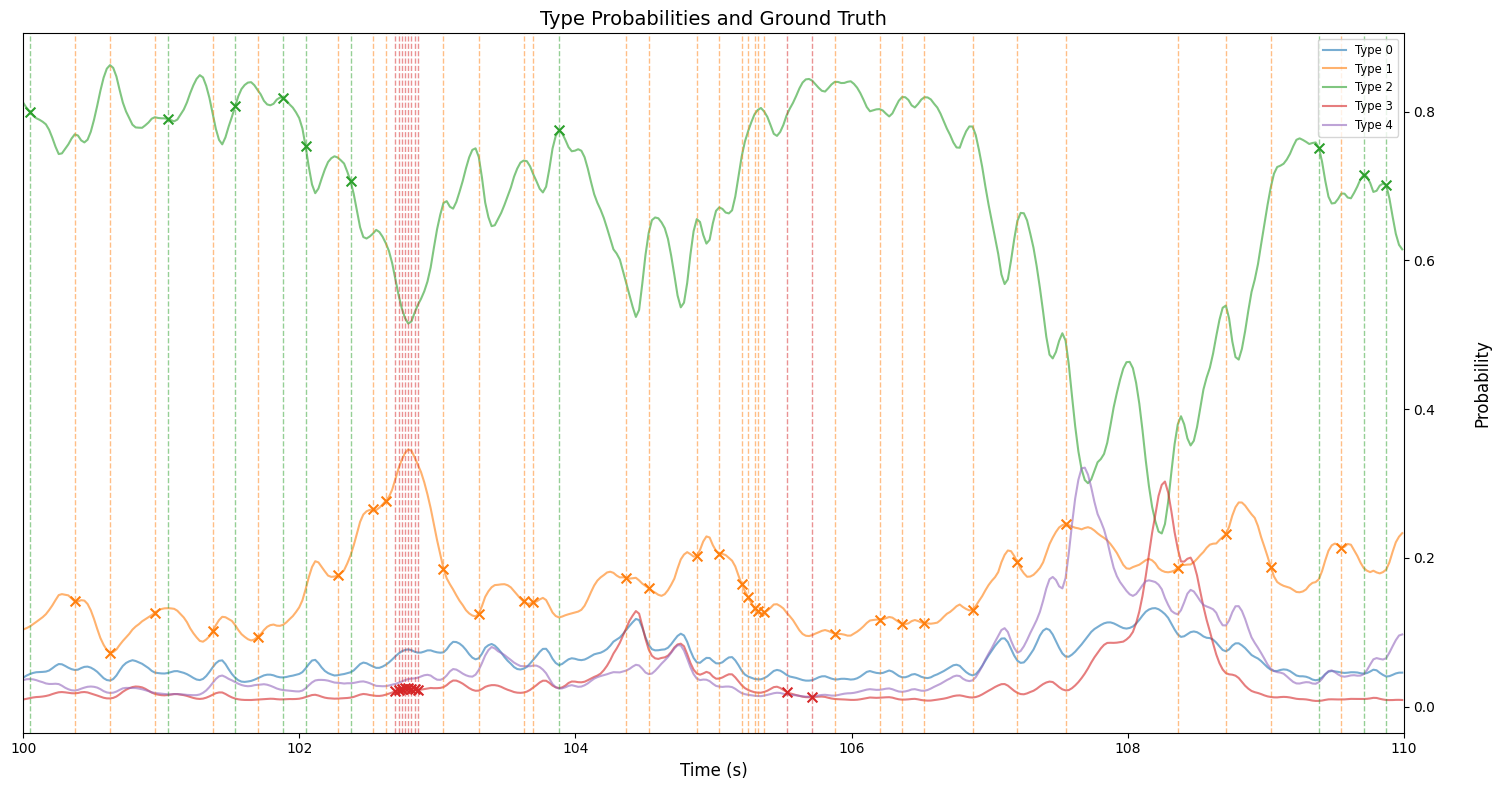

Epoch 10/10, Train Loss: 0.5092, Train Acc: 521054.17%, Val Loss: 1.2328, Val Acc: 310921.44%


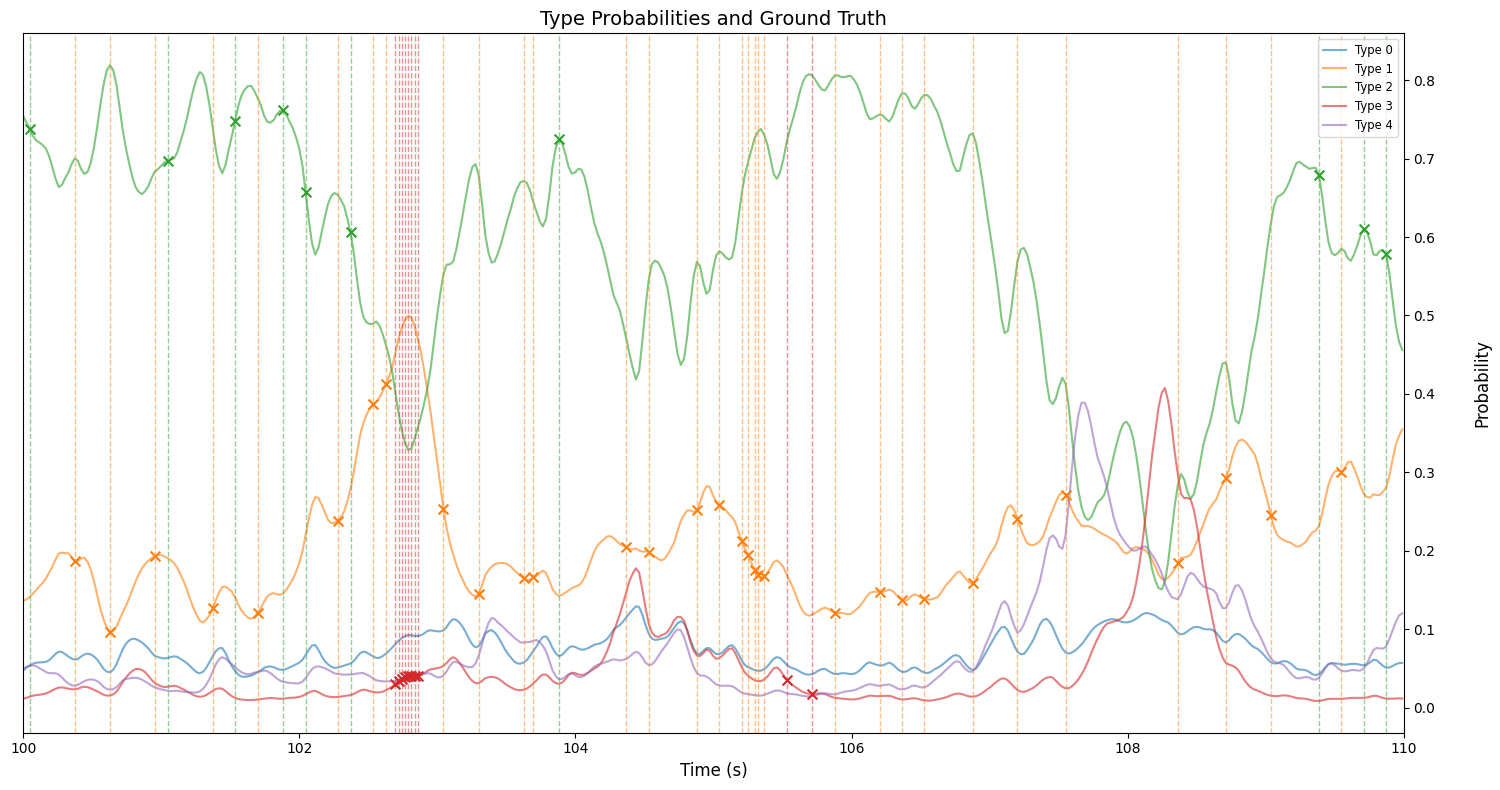

In [ ]:

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, num_types, class_weights)
    val_loss, val_acc = validate_epoch(model, val_loader, device, num_types, class_weights)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_multitask_lstm_model.pth")
        print("Saved Best Model")

    sample_mel, sample_labels = val_dataset[1]
    sample_mel_np = sample_mel.numpy()
    sample_labels_np = sample_labels.numpy()
    

    with torch.no_grad():
        mel_tensor = sample_mel.unsqueeze(0).to(device)  # (1, seq_len, input_size)
        type_pred = model(mel_tensor)
        type_pred = type_pred.squeeze(0).cpu().numpy()    # (seq_len, num_types)

    visualize_predictions(
        mel=sample_mel_np,
        labels=sample_labels_np,
        preds=type_pred,
        start_time=100,   
        end_time=110    
    )


0 : Click
1 : Hold
2 : Long hold
3 : Drag
4 : Drag child
5 : Flick
6 : Click drag
7 : Click drag child

Type 0: None
Type 1: Click, Flick
Type 2: Hold, Long hold
Type 3: Drag, Drag child4
type 4: Click drag, Click drag child